In [1]:
# Import modules
import sys

In [2]:
# Import custom modules
sys.path.append('../')

from src.models.upload_data import *

In [3]:
# Set notebook attributes
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
# Set magic attributes
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
# Configuration
args = argparse.ArgumentParser()
args.add_argument("--config", default="../params.yaml")
parsed_args = vars(args.parse_args(""))
config_path = parsed_args['config']

### FTD

In [6]:
%%time
# Data ingestion, cleaning/wrangling
# convert_to_parquet(config_path, 'ftd', 'excel')
df_ftd_raw = pull_data(config_path, ftd_sql(), 'DWH', 'ftd', False, 'raw')

Currently loading ftd data set ...
Time taken is 0 seconds ...


,store_number,update_flag,reinstatement_reason
31,565405,0,first time defaulters during election risk mitigation measures
6,7783143,1,first time defaulters during election risk mitigation measures


---------------------------------------------------------------------------------------------------------------------------------------
CPU times: total: 46.9 ms
Wall time: 98.5 ms


In [7]:
%%time
# Data ingestion, cleaning/wrangling
df_ftd_clean = clean_dataset(config_path, 'ftd')


Currently cleaning ftd data set ...


,store_number,update_flag,reinstatement_reason
34,7850801,1,first time defaulters during election risk mitigation measures


---------------------------------------------------------------------------------------------------------------------------------------
CPU times: total: 62.5 ms
Wall time: 64 ms


In [8]:
# Final dataset schema
df_ftd_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 45
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   store_number          42 non-null     object
 1   update_flag           42 non-null     int64 
 2   reinstatement_reason  42 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


### FTD Loan IDs

In [9]:
# Data loading
df_ftd_loans = pd.read_excel('../data/raw/20.6_JN_ftd_defaulters.xlsx')
df_ftd_loans['store_number'] = df_ftd_loans['store_number'].astype('str')
df_ftd_loans['loan_mifos_id'] = df_ftd_loans['loan_mifos_id'].astype('str')
df_ftd_loans.drop_duplicates(inplace=True)
df_ftd_loans.sample(2)

,store_number,final_21_limit,final_7_limit,final_1_limit,loan_mifos_id,loan_status,term_frequency,principal_disbursed,principal_outstanding,interest_outstanding,fee_charges_charged,fee_charges_outstanding,penalty_charges_charged,penalty_charges_outstanding,total_expected_repayment,total_repayment,total_outstanding,safaricom_loan_balance,bloom_version,disbursed_on_date,expected_matured_on_date,national_id,mobile_number,first_name,middle_name,last_name,iprs_first_name,iprs_other_name,iprs_surname,company_name,CFID,Disbursment,Disposition,Outstanding Bal,Repayment
5,7207408,50300,29000,29000,156467,300,21,23600,23600.00,1793.61,314.37,314.37,12121.03,12121.03,37829.01,0.00,37829.01,40231.71,2,2022-07-15,2022-08-05,11679799,254794456582,Grace,Nyakanini,Mathangani,Grace,Nyakanini,Mathangani,CRUNCHY RANCH,79918.00,QGF0HM2QAS,Ringing No response,37829.01,0
8,7084709,200000,200000,200000,168842,300,7,5000,5000.00,130.00,168.99,168.99,2349.90,2349.90,7648.89,0.00,7648.89,7839.72,2,2022-07-21,2022-07-28,32671836,254702350765,Charles,Kariuki,Mwangi,Zipporah,Nyakio,Muthoni,CHARLES KARIUKI MWANGI,73926.00,QGL9TQWDG3,promise to pay,7648.89,0


In [10]:
# Data set dimension
df_ftd_loans.shape

(42, 35)

### Merge Datasets

In [11]:
# Merge datasets
df_ftd_merge_loans = df_ftd_clean.merge(df_ftd_loans, on=['store_number'], how='left')
df_ftd_merge_loans.sample(2)

,store_number,update_flag,reinstatement_reason,final_21_limit,final_7_limit,final_1_limit,loan_mifos_id,loan_status,term_frequency,principal_disbursed,principal_outstanding,interest_outstanding,fee_charges_charged,fee_charges_outstanding,penalty_charges_charged,penalty_charges_outstanding,total_expected_repayment,total_repayment,total_outstanding,safaricom_loan_balance,bloom_version,disbursed_on_date,expected_matured_on_date,national_id,mobile_number,first_name,middle_name,last_name,iprs_first_name,iprs_other_name,iprs_surname,company_name,CFID,Disbursment,Disposition,Outstanding Bal,Repayment
6,7068691,1,first time defaulters during election risk mitigation measures,6200,3600,3600,173055,300,21,2100,2100.00,159.60,281.34,281.34,1206.11,1206.11,3747.05,0.00,3747.05,3613.91,2,2022-07-23,2022-08-13,27062499,254729451568,Naom,Mukai,Musyoki,Naom,Mukai,Musyoki,NAOM MUKAI MUSYOKI 2,85306.00,QGN8X6TS3E,Promise to Pay,3747.05,0
33,610444,1,first time defaulters during election risk mitigation measures,2400,1400,1400,182974,300,7,2400,1644.61,0.00,130.64,0.00,626.56,0.00,3219.61,1575.00,1644.61,1625.88,2,2022-08-01,2022-08-08,35890090,254720598291,Benson,Maina,Maina,Richmond,Mbuvi,Mwongela,MAWE MBILI RESORT CLUB RESTAURANT…………,81483.00,QH16H6G386,Negotiation in Progress,1644.61,0


In [12]:
# Data set dimension
df_ftd_merge_loans.shape

(42, 37)

In [13]:
# Not in FTD list
df_ftd_merge_loans.loc[df_ftd_merge_loans.update_flag.isna(), 'store_number'].values

array([], dtype=object)

In [14]:
# FTDs loans
df_ftd_merge_loans['loan_mifos_id'].values

array(['168842', '171762', '172647', '173578', '178361', '156467',
       '173055', '173132', '175911', '175951', '177310', '178196',
       '178318', '179599', '179564', '180342', '151040', '152329',
       '151774', '155671', '156274', '160931', '161611', '179756',
       '179565', '180530', '181009', '180594', '181553', '181546',
       '181661', '181963', '181879', '182974', '182084', '183370',
       '183185', '182932', '184282', '183243', '184403', '184389'],
      dtype=object)

### FTDs Performance

In [15]:
%%time
# Data ingestion, cleaning/wrangling
# convert_to_parquet(config_path, 'ftd', 'excel')
df_ftd_performance_raw = pull_data(config_path, ftd_lftsv_sql(), 'DWH', 'ftd_lftsv', False, 'raw')

Currently loading ftd_lftsv data set ...
Time taken is 0 seconds ...


,client_mifos_id,client_mobile_number,loan_status,loan_mifos_id,term_frequency,principal_disbursed,principal_repaid,interest_charged,interest_repaid,fee_charges_charged,fee_charges_repaid,penalty_charges_charged,penalty_charges_repaid,total_expected_repayment,total_repayment,total_outstanding,safaricom_loan_balance,safaricom_loan_balance_date,disbursed_on_date,expected_matured_on_date,closed_on_date,store_number,bloom_version,src_crdt_score,due_date_fixed,end_rollover_date_fixed,expected_dpd90
4,95000,254726474667,300,175951,21,9400.00,0.00,714.41,0.00,121.17,0.00,3561.63,3000.00,13797.21,3000.00,10797.21,11662.64,2023-02-22,2022-07-25,2022-08-15,None,7263386,2.00,463.00,2022-08-15,2022-08-20,2022-11-18
41,20665,254720668829,300,173578,7,2900.00,2597.91,75.40,75.40,424.79,424.79,1459.61,1459.61,4859.80,4557.71,302.09,0.00,2022-12-07 07:56:07,2022-07-23,2022-07-30,None,661914,2.00,446.00,2022-07-30,2022-08-02,2022-10-31


---------------------------------------------------------------------------------------------------------------------------------------
CPU times: total: 15.6 ms
Wall time: 63.6 ms


In [16]:
%%time
# Data ingestion, cleaning/wrangling
df_ftd_performance_clean = clean_dataset(config_path, 'ftd_lftsv')


Currently cleaning ftd_lftsv data set ...


,client_mifos_id,client_mobile_number,loan_status,loan_mifos_id,term_frequency,principal_disbursed,principal_repaid,interest_charged,interest_repaid,fee_charges_charged,fee_charges_repaid,penalty_charges_charged,penalty_charges_repaid,total_expected_repayment,total_repayment,total_outstanding,disbursed_on_date,expected_matured_on_date,closed_on_date,store_number,bloom_version,src_crdt_score,due_date_fixed,end_rollover_date_fixed,expected_dpd90,safaricom_loan_balance,safaricom_loan_balance_date
1,109561,254724551089,300,152329,21,4800.00,3446.49,364.80,364.80,1272.83,1272.83,2593.50,2593.50,9031.13,7677.62,1353.51,2022-07-11,2022-08-01,None,7088854,2.00,481.00,2022-08-01,2022-08-06,2022-11-04,3500.62,2022-12-05 21:59:26


---------------------------------------------------------------------------------------------------------------------------------------
CPU times: total: 31.2 ms
Wall time: 73.2 ms


In [17]:
# Final dataset schema
df_ftd_performance_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   client_mifos_id              42 non-null     object 
 1   client_mobile_number         42 non-null     object 
 2   loan_status                  42 non-null     int64  
 3   loan_mifos_id                42 non-null     object 
 4   term_frequency               42 non-null     int64  
 5   principal_disbursed          42 non-null     float64
 6   principal_repaid             42 non-null     float64
 7   interest_charged             42 non-null     float64
 8   interest_repaid              42 non-null     float64
 9   fee_charges_charged          42 non-null     float64
 10  fee_charges_repaid           42 non-null     float64
 11  penalty_charges_charged      42 non-null     float64
 12  penalty_charges_repaid       42 non-null     float64
 13  total_expected_repayme

### Merge Datasets

In [18]:
# Merge datasets
df_ftd_merge_loans_performance = df_ftd_merge_loans.merge(df_ftd_performance_clean, on=['loan_mifos_id', 'store_number'], how='left', suffixes=('_before', '_after'))
df_ftd_merge_loans_performance.sample(2)

,store_number,update_flag,reinstatement_reason,final_21_limit,final_7_limit,final_1_limit,loan_mifos_id,loan_status_before,term_frequency_before,principal_disbursed_before,principal_outstanding,interest_outstanding,fee_charges_charged_before,fee_charges_outstanding,penalty_charges_charged_before,penalty_charges_outstanding,total_expected_repayment_before,total_repayment_before,total_outstanding_before,safaricom_loan_balance_before,bloom_version_before,disbursed_on_date_before,expected_matured_on_date_before,national_id,mobile_number,first_name,middle_name,last_name,iprs_first_name,iprs_other_name,iprs_surname,company_name,CFID,Disbursment,Disposition,Outstanding Bal,Repayment,client_mifos_id,client_mobile_number,loan_status_after,term_frequency_after,principal_disbursed_after,principal_repaid,interest_charged,interest_repaid,fee_charges_charged_after,fee_charges_repaid,penalty_charges_charged_after,penalty_charges_repaid,total_expected_repayment_after,total_repayment_after,total_outstanding_after,disbursed_on_date_after,expected_matured_on_date_after,closed_on_date,bloom_version_after,src_crdt_score,due_date_fixed,end_rollover_date_fixed,expected_dpd90,safaricom_loan_balance_after,safaricom_loan_balance_date
16,7618105,1,first time defaulters during election risk mitigation measures,0,4100,4100,151040,300,21,2400,2400.00,182.40,31.97,31.97,1214.67,1214.67,3829.04,0.00,3829.04,4071.57,2,2022-07-11,2022-08-01,13223426,254714699990,Maina,Mwangi,Mwangi,Maina,Mwangi,Gathithi,MAINA MWANGI,76897.00,QGB49JF5N8,Negotiation in Progress,3829.04,0,43014,254714699990,300,21,2400.00,0.00,182.40,0.00,31.97,0.00,1214.67,0.00,3829.04,0.00,3829.04,2022-07-11,2022-08-01,None,2.00,465.00,2022-08-01,2022-08-06,2022-11-04,4071.57,2023-02-22
7,759602,1,first time defaulters during election risk mitigation measures,77000,43300,43300,173132,300,21,43000,43000.00,3268.00,472.77,472.77,22201.03,22201.03,68941.80,0.00,68941.80,74006.36,2,2022-07-23,2022-08-13,8091257,254714126189,Samuel,Otieno,Olage,Samuel,Otieno,Olage,SAMUEL OTIENO OLAGE,85299.00,QGN6X9KQXU,Promise to Pay,68941.80,0,89778,254714126189,300,21,43000.00,0.00,3268.00,0.00,472.77,0.00,22201.03,0.00,68941.80,0.00,68941.80,2022-07-23,2022-08-13,None,2.00,440.00,2022-08-13,2022-08-18,2022-11-16,74006.36,2023-02-22


In [19]:
# Data set dimension
df_ftd_merge_loans_performance.shape

(42, 62)

### Diagnostic

In [20]:
# Update flag 0
df_ftd_merge_loans_performance[df_ftd_merge_loans_performance.update_flag == 0]

,store_number,update_flag,reinstatement_reason,final_21_limit,final_7_limit,final_1_limit,loan_mifos_id,loan_status_before,term_frequency_before,principal_disbursed_before,principal_outstanding,interest_outstanding,fee_charges_charged_before,fee_charges_outstanding,penalty_charges_charged_before,penalty_charges_outstanding,total_expected_repayment_before,total_repayment_before,total_outstanding_before,safaricom_loan_balance_before,bloom_version_before,disbursed_on_date_before,expected_matured_on_date_before,national_id,mobile_number,first_name,middle_name,last_name,iprs_first_name,iprs_other_name,iprs_surname,company_name,CFID,Disbursment,Disposition,Outstanding Bal,Repayment,client_mifos_id,client_mobile_number,loan_status_after,term_frequency_after,principal_disbursed_after,principal_repaid,interest_charged,interest_repaid,fee_charges_charged_after,fee_charges_repaid,penalty_charges_charged_after,penalty_charges_repaid,total_expected_repayment_after,total_repayment_after,total_outstanding_after,disbursed_on_date_after,expected_matured_on_date_after,closed_on_date,bloom_version_after,src_crdt_score,due_date_fixed,end_rollover_date_fixed,expected_dpd90,safaricom_loan_balance_after,safaricom_loan_balance_date
3,661914,0,first time defaulters during election risk mitigation measures,50300,29600,29600,173578,300,7,2900,2900.00,75.40,424.79,424.79,1459.61,1459.61,4859.80,0.00,4859.80,4557.71,2,2022-07-23,2022-07-30,27408880,254720668829,David,Munyui,B,David,Munyui,Njeri,MOBIFIX TECHNOLOGIES 1,75106.00,QGN8XLL9RC,Promise to Pay,4859.80,0,20665,254720668829,300,7,2900.00,2597.91,75.40,75.40,424.79,424.79,1459.61,1459.61,4859.80,4557.71,302.09,2022-07-23,2022-07-30,None,2.00,446.00,2022-07-30,2022-08-02,2022-10-31,0.00,2022-12-07 07:56:07
8,786519,0,first time defaulters during election risk mitigation measures,200000,200000,200000,175911,600,21,200000,0.00,0.00,3465.44,0.00,102893.21,0.00,321558.66,321558.66,0.00,81408.82,2,2022-07-25,2022-08-15,28398971,254725646599,Elias,Karani,Ndambiri,Elias,Karani,Ndambiri,ELLYN HOME DECOR,NaN,QGP12MQHNB,NaN,0.00,0,62910,254725646599,300,21,200000.00,138441.34,15200.01,15200.01,3465.44,3465.44,102893.21,102893.21,321558.66,260000.00,61558.66,2022-07-25,2022-08-15,None,2.00,495.00,2022-08-15,2022-08-20,2022-11-18,81408.82,2023-02-22
27,565405,0,first time defaulters during election risk mitigation measures,163200,93300,93300,180594,600,7,95000,0.00,0.00,1825.38,0.00,2684.46,0.00,101979.85,101979.85,0.00,27470.00,2,2022-07-30,2022-08-06,27585704,254728939176,Daniel,Mwanua,Msafari,Daniel,Mwanua,Msafari,MSTARI HARDWARE4,NaN,QGU2CG4ACS,NaN,0.00,0,14180,254728939176,600,7,95000.00,95000.00,2470.01,2470.01,1825.38,1825.38,2684.46,2684.46,101979.85,101979.85,0.00,2022-07-30,2022-08-06,2022-11-24,2.00,510.00,2022-08-06,2022-08-09,2022-11-07,27470.00,2022-08-04 07:56:07


In [21]:
# Proportion of Loan status
df_ftd_merge_loans_performance.loan_status_after.value_counts()
#300 active
#600 closed

300    38
600     4
Name: loan_status_after, dtype: int64

In [22]:
# Present status 600
df_ftd_merge_loans_performance[df_ftd_merge_loans_performance.loan_status_after == 600]

,store_number,update_flag,reinstatement_reason,final_21_limit,final_7_limit,final_1_limit,loan_mifos_id,loan_status_before,term_frequency_before,principal_disbursed_before,principal_outstanding,interest_outstanding,fee_charges_charged_before,fee_charges_outstanding,penalty_charges_charged_before,penalty_charges_outstanding,total_expected_repayment_before,total_repayment_before,total_outstanding_before,safaricom_loan_balance_before,bloom_version_before,disbursed_on_date_before,expected_matured_on_date_before,national_id,mobile_number,first_name,middle_name,last_name,iprs_first_name,iprs_other_name,iprs_surname,company_name,CFID,Disbursment,Disposition,Outstanding Bal,Repayment,client_mifos_id,client_mobile_number,loan_status_after,term_frequency_after,principal_disbursed_after,principal_repaid,interest_charged,interest_repaid,fee_charges_charged_after,fee_charges_repaid,penalty_charges_charged_after,penalty_charges_repaid,total_expected_repayment_after,total_repayment_after,total_outstanding_after,disbursed_on_date_after,expected_matured_on_date_after,closed_on_date,bloom_version_after,src_crdt_score,due_date_fixed,end_rollover_date_fixed,expected_dpd90,safaricom_loan_balance_after,safaricom_loan_balance_date
18,7392614,1,first time defaulters during election risk mitigation measures,6300,4000,4000,151774,300,21,2900,2701.83,0.00,90.25,0.00,1491.18,0.00,4701.83,2000.00,2701.83,2919.86,2,2022-07-11,2022-08-01,11509098,254721892343,Merchant,NaN,NaN,Evanson,Waweru,Mburu,EVANSON WAWERU MBURU,76769.00,QGB1AR96Q3,Promise to pay,1701.83,1000,101125,254721892343,600,21,2900.00,2900.00,220.40,220.40,90.25,90.25,1491.18,1491.18,4701.83,4701.83,0.00,2022-07-11,2022-08-01,None,2.00,407.00,2022-08-01,2022-08-06,2022-11-04,0.00,2022-12-12 09:20:32
19,7237719,1,first time defaulters during election risk mitigation measures,0,42100,42100,155671,300,21,8000,8000.00,608.01,93.74,93.74,4087.82,4087.82,12789.57,0.00,12789.57,13621.39,2,2022-07-14,2022-08-04,24180343,254720999599,Willy,Karuiru,Kimaru,Willy,Karuiru,Kimaru,DESTINY WINES AND SPIRITS,79083.00,QGE4FWGIWQ,Ringing No response,12789.57,0,107949,254720999599,600,21,8000.00,8000.00,608.01,608.01,93.74,93.74,4087.82,4087.82,12789.57,12789.57,0.00,2022-07-14,2022-08-04,None,2.00,479.00,2022-08-04,2022-08-09,2022-11-07,0.00,2023-02-14 12:26:16
27,565405,0,first time defaulters during election risk mitigation measures,163200,93300,93300,180594,600,7,95000,0.00,0.00,1825.38,0.00,2684.46,0.00,101979.85,101979.85,0.00,27470.00,2,2022-07-30,2022-08-06,27585704,254728939176,Daniel,Mwanua,Msafari,Daniel,Mwanua,Msafari,MSTARI HARDWARE4,NaN,QGU2CG4ACS,NaN,0.00,0,14180,254728939176,600,7,95000.00,95000.00,2470.01,2470.01,1825.38,1825.38,2684.46,2684.46,101979.85,101979.85,0.00,2022-07-30,2022-08-06,2022-11-24,2.00,510.00,2022-08-06,2022-08-09,2022-11-07,27470.00,2022-08-04 07:56:07
37,7275089,1,first time defaulters during election risk mitigation measures,18100,10300,10300,182932,300,7,9400,9400.00,244.41,538.60,538.60,4640.44,4640.44,14823.45,0.00,14823.45,14933.60,2,2022-08-01,2022-08-08,3316260,254727617117,Juliana,Cherono,Cherono,Salomon,NaN,Sabai,JULIANA CHERONO,81505.00,QH13H2OFTL,Ringing No Response,14823.45,0,34923,254727617117,600,7,9400.00,9400.00,244.41,244.41,538.60,538.60,4640.44,4640.44,14823.45,14823.45,0.00,2022-08-01,2022-08-08,None,2.00,442.00,2022-08-08,2022-08-11,2022-11-09,0.00,2023-02-09 08:21:31


<AxesSubplot: xlabel='loan_status_after', ylabel='loan_status_before'>

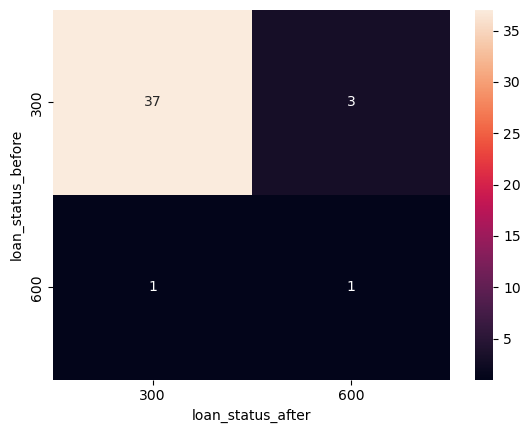

In [23]:
# Loan status progression
sns.heatmap(pd.crosstab(df_ftd_merge_loans_performance.loan_status_before, df_ftd_merge_loans_performance.loan_status_after), annot=True)

In [24]:
# Safaricom balance 0
df_ftd_merge_loans_performance[df_ftd_merge_loans_performance.safaricom_loan_balance_after == 0]

,store_number,update_flag,reinstatement_reason,final_21_limit,final_7_limit,final_1_limit,loan_mifos_id,loan_status_before,term_frequency_before,principal_disbursed_before,principal_outstanding,interest_outstanding,fee_charges_charged_before,fee_charges_outstanding,penalty_charges_charged_before,penalty_charges_outstanding,total_expected_repayment_before,total_repayment_before,total_outstanding_before,safaricom_loan_balance_before,bloom_version_before,disbursed_on_date_before,expected_matured_on_date_before,national_id,mobile_number,first_name,middle_name,last_name,iprs_first_name,iprs_other_name,iprs_surname,company_name,CFID,Disbursment,Disposition,Outstanding Bal,Repayment,client_mifos_id,client_mobile_number,loan_status_after,term_frequency_after,principal_disbursed_after,principal_repaid,interest_charged,interest_repaid,fee_charges_charged_after,fee_charges_repaid,penalty_charges_charged_after,penalty_charges_repaid,total_expected_repayment_after,total_repayment_after,total_outstanding_after,disbursed_on_date_after,expected_matured_on_date_after,closed_on_date,bloom_version_after,src_crdt_score,due_date_fixed,end_rollover_date_fixed,expected_dpd90,safaricom_loan_balance_after,safaricom_loan_balance_date
3,661914,0,first time defaulters during election risk mitigation measures,50300,29600,29600,173578,300,7,2900,2900.00,75.40,424.79,424.79,1459.61,1459.61,4859.80,0.00,4859.80,4557.71,2,2022-07-23,2022-07-30,27408880,254720668829,David,Munyui,B,David,Munyui,Njeri,MOBIFIX TECHNOLOGIES 1,75106.00,QGN8XLL9RC,Promise to Pay,4859.80,0,20665,254720668829,300,7,2900.00,2597.91,75.40,75.40,424.79,424.79,1459.61,1459.61,4859.80,4557.71,302.09,2022-07-23,2022-07-30,None,2.00,446.00,2022-07-30,2022-08-02,2022-10-31,0.00,2022-12-07 07:56:07
18,7392614,1,first time defaulters during election risk mitigation measures,6300,4000,4000,151774,300,21,2900,2701.83,0.00,90.25,0.00,1491.18,0.00,4701.83,2000.00,2701.83,2919.86,2,2022-07-11,2022-08-01,11509098,254721892343,Merchant,NaN,NaN,Evanson,Waweru,Mburu,EVANSON WAWERU MBURU,76769.00,QGB1AR96Q3,Promise to pay,1701.83,1000,101125,254721892343,600,21,2900.00,2900.00,220.40,220.40,90.25,90.25,1491.18,1491.18,4701.83,4701.83,0.00,2022-07-11,2022-08-01,None,2.00,407.00,2022-08-01,2022-08-06,2022-11-04,0.00,2022-12-12 09:20:32
19,7237719,1,first time defaulters during election risk mitigation measures,0,42100,42100,155671,300,21,8000,8000.00,608.01,93.74,93.74,4087.82,4087.82,12789.57,0.00,12789.57,13621.39,2,2022-07-14,2022-08-04,24180343,254720999599,Willy,Karuiru,Kimaru,Willy,Karuiru,Kimaru,DESTINY WINES AND SPIRITS,79083.00,QGE4FWGIWQ,Ringing No response,12789.57,0,107949,254720999599,600,21,8000.00,8000.00,608.01,608.01,93.74,93.74,4087.82,4087.82,12789.57,12789.57,0.00,2022-07-14,2022-08-04,None,2.00,479.00,2022-08-04,2022-08-09,2022-11-07,0.00,2023-02-14 12:26:16
37,7275089,1,first time defaulters during election risk mitigation measures,18100,10300,10300,182932,300,7,9400,9400.00,244.41,538.60,538.60,4640.44,4640.44,14823.45,0.00,14823.45,14933.60,2,2022-08-01,2022-08-08,3316260,254727617117,Juliana,Cherono,Cherono,Salomon,NaN,Sabai,JULIANA CHERONO,81505.00,QH13H2OFTL,Ringing No Response,14823.45,0,34923,254727617117,600,7,9400.00,9400.00,244.41,244.41,538.60,538.60,4640.44,4640.44,14823.45,14823.45,0.00,2022-08-01,2022-08-08,None,2.00,442.00,2022-08-08,2022-08-11,2022-11-09,0.00,2023-02-09 08:21:31


In [25]:
# Asante balance 0
df_ftd_merge_loans_performance[df_ftd_merge_loans_performance.total_outstanding_after == 0]

,store_number,update_flag,reinstatement_reason,final_21_limit,final_7_limit,final_1_limit,loan_mifos_id,loan_status_before,term_frequency_before,principal_disbursed_before,principal_outstanding,interest_outstanding,fee_charges_charged_before,fee_charges_outstanding,penalty_charges_charged_before,penalty_charges_outstanding,total_expected_repayment_before,total_repayment_before,total_outstanding_before,safaricom_loan_balance_before,bloom_version_before,disbursed_on_date_before,expected_matured_on_date_before,national_id,mobile_number,first_name,middle_name,last_name,iprs_first_name,iprs_other_name,iprs_surname,company_name,CFID,Disbursment,Disposition,Outstanding Bal,Repayment,client_mifos_id,client_mobile_number,loan_status_after,term_frequency_after,principal_disbursed_after,principal_repaid,interest_charged,interest_repaid,fee_charges_charged_after,fee_charges_repaid,penalty_charges_charged_after,penalty_charges_repaid,total_expected_repayment_after,total_repayment_after,total_outstanding_after,disbursed_on_date_after,expected_matured_on_date_after,closed_on_date,bloom_version_after,src_crdt_score,due_date_fixed,end_rollover_date_fixed,expected_dpd90,safaricom_loan_balance_after,safaricom_loan_balance_date
18,7392614,1,first time defaulters during election risk mitigation measures,6300,4000,4000,151774,300,21,2900,2701.83,0.00,90.25,0.00,1491.18,0.00,4701.83,2000.00,2701.83,2919.86,2,2022-07-11,2022-08-01,11509098,254721892343,Merchant,NaN,NaN,Evanson,Waweru,Mburu,EVANSON WAWERU MBURU,76769.00,QGB1AR96Q3,Promise to pay,1701.83,1000,101125,254721892343,600,21,2900.00,2900.00,220.40,220.40,90.25,90.25,1491.18,1491.18,4701.83,4701.83,0.00,2022-07-11,2022-08-01,None,2.00,407.00,2022-08-01,2022-08-06,2022-11-04,0.00,2022-12-12 09:20:32
19,7237719,1,first time defaulters during election risk mitigation measures,0,42100,42100,155671,300,21,8000,8000.00,608.01,93.74,93.74,4087.82,4087.82,12789.57,0.00,12789.57,13621.39,2,2022-07-14,2022-08-04,24180343,254720999599,Willy,Karuiru,Kimaru,Willy,Karuiru,Kimaru,DESTINY WINES AND SPIRITS,79083.00,QGE4FWGIWQ,Ringing No response,12789.57,0,107949,254720999599,600,21,8000.00,8000.00,608.01,608.01,93.74,93.74,4087.82,4087.82,12789.57,12789.57,0.00,2022-07-14,2022-08-04,None,2.00,479.00,2022-08-04,2022-08-09,2022-11-07,0.00,2023-02-14 12:26:16
27,565405,0,first time defaulters during election risk mitigation measures,163200,93300,93300,180594,600,7,95000,0.00,0.00,1825.38,0.00,2684.46,0.00,101979.85,101979.85,0.00,27470.00,2,2022-07-30,2022-08-06,27585704,254728939176,Daniel,Mwanua,Msafari,Daniel,Mwanua,Msafari,MSTARI HARDWARE4,NaN,QGU2CG4ACS,NaN,0.00,0,14180,254728939176,600,7,95000.00,95000.00,2470.01,2470.01,1825.38,1825.38,2684.46,2684.46,101979.85,101979.85,0.00,2022-07-30,2022-08-06,2022-11-24,2.00,510.00,2022-08-06,2022-08-09,2022-11-07,27470.00,2022-08-04 07:56:07
37,7275089,1,first time defaulters during election risk mitigation measures,18100,10300,10300,182932,300,7,9400,9400.00,244.41,538.60,538.60,4640.44,4640.44,14823.45,0.00,14823.45,14933.60,2,2022-08-01,2022-08-08,3316260,254727617117,Juliana,Cherono,Cherono,Salomon,NaN,Sabai,JULIANA CHERONO,81505.00,QH13H2OFTL,Ringing No Response,14823.45,0,34923,254727617117,600,7,9400.00,9400.00,244.41,244.41,538.60,538.60,4640.44,4640.44,14823.45,14823.45,0.00,2022-08-01,2022-08-08,None,2.00,442.00,2022-08-08,2022-08-11,2022-11-09,0.00,2023-02-09 08:21:31


In [26]:
# Safaricom and Asante balance 0
df_ftd_merge_loans_performance[(df_ftd_merge_loans_performance.safaricom_loan_balance_after == 0) | (df_ftd_merge_loans_performance.total_outstanding_after == 0)]

,store_number,update_flag,reinstatement_reason,final_21_limit,final_7_limit,final_1_limit,loan_mifos_id,loan_status_before,term_frequency_before,principal_disbursed_before,principal_outstanding,interest_outstanding,fee_charges_charged_before,fee_charges_outstanding,penalty_charges_charged_before,penalty_charges_outstanding,total_expected_repayment_before,total_repayment_before,total_outstanding_before,safaricom_loan_balance_before,bloom_version_before,disbursed_on_date_before,expected_matured_on_date_before,national_id,mobile_number,first_name,middle_name,last_name,iprs_first_name,iprs_other_name,iprs_surname,company_name,CFID,Disbursment,Disposition,Outstanding Bal,Repayment,client_mifos_id,client_mobile_number,loan_status_after,term_frequency_after,principal_disbursed_after,principal_repaid,interest_charged,interest_repaid,fee_charges_charged_after,fee_charges_repaid,penalty_charges_charged_after,penalty_charges_repaid,total_expected_repayment_after,total_repayment_after,total_outstanding_after,disbursed_on_date_after,expected_matured_on_date_after,closed_on_date,bloom_version_after,src_crdt_score,due_date_fixed,end_rollover_date_fixed,expected_dpd90,safaricom_loan_balance_after,safaricom_loan_balance_date
3,661914,0,first time defaulters during election risk mitigation measures,50300,29600,29600,173578,300,7,2900,2900.00,75.40,424.79,424.79,1459.61,1459.61,4859.80,0.00,4859.80,4557.71,2,2022-07-23,2022-07-30,27408880,254720668829,David,Munyui,B,David,Munyui,Njeri,MOBIFIX TECHNOLOGIES 1,75106.00,QGN8XLL9RC,Promise to Pay,4859.80,0,20665,254720668829,300,7,2900.00,2597.91,75.40,75.40,424.79,424.79,1459.61,1459.61,4859.80,4557.71,302.09,2022-07-23,2022-07-30,None,2.00,446.00,2022-07-30,2022-08-02,2022-10-31,0.00,2022-12-07 07:56:07
18,7392614,1,first time defaulters during election risk mitigation measures,6300,4000,4000,151774,300,21,2900,2701.83,0.00,90.25,0.00,1491.18,0.00,4701.83,2000.00,2701.83,2919.86,2,2022-07-11,2022-08-01,11509098,254721892343,Merchant,NaN,NaN,Evanson,Waweru,Mburu,EVANSON WAWERU MBURU,76769.00,QGB1AR96Q3,Promise to pay,1701.83,1000,101125,254721892343,600,21,2900.00,2900.00,220.40,220.40,90.25,90.25,1491.18,1491.18,4701.83,4701.83,0.00,2022-07-11,2022-08-01,None,2.00,407.00,2022-08-01,2022-08-06,2022-11-04,0.00,2022-12-12 09:20:32
19,7237719,1,first time defaulters during election risk mitigation measures,0,42100,42100,155671,300,21,8000,8000.00,608.01,93.74,93.74,4087.82,4087.82,12789.57,0.00,12789.57,13621.39,2,2022-07-14,2022-08-04,24180343,254720999599,Willy,Karuiru,Kimaru,Willy,Karuiru,Kimaru,DESTINY WINES AND SPIRITS,79083.00,QGE4FWGIWQ,Ringing No response,12789.57,0,107949,254720999599,600,21,8000.00,8000.00,608.01,608.01,93.74,93.74,4087.82,4087.82,12789.57,12789.57,0.00,2022-07-14,2022-08-04,None,2.00,479.00,2022-08-04,2022-08-09,2022-11-07,0.00,2023-02-14 12:26:16
27,565405,0,first time defaulters during election risk mitigation measures,163200,93300,93300,180594,600,7,95000,0.00,0.00,1825.38,0.00,2684.46,0.00,101979.85,101979.85,0.00,27470.00,2,2022-07-30,2022-08-06,27585704,254728939176,Daniel,Mwanua,Msafari,Daniel,Mwanua,Msafari,MSTARI HARDWARE4,NaN,QGU2CG4ACS,NaN,0.00,0,14180,254728939176,600,7,95000.00,95000.00,2470.01,2470.01,1825.38,1825.38,2684.46,2684.46,101979.85,101979.85,0.00,2022-07-30,2022-08-06,2022-11-24,2.00,510.00,2022-08-06,2022-08-09,2022-11-07,27470.00,2022-08-04 07:56:07
37,7275089,1,first time defaulters during election risk mitigation measures,18100,10300,10300,182932,300,7,9400,9400.00,244.41,538.60,538.60,4640.44,4640.44,14823.45,0.00,14823.45,14933.60,2,2022-08-01,2022-08-08,3316260,254727617117,Juliana,Cherono,Cherono,Salomon,NaN,Sabai,JULIANA CHERONO,81505.00,QH13H2OFTL,Ringing No Response,14823.45,0,34923,254727617117,600,7,9400.00,9400.00,244.41,244.41,538.60,538.60,4640.44,4640.44,14823.45,14823.45,0.00,2022-08-01,2022-08-08,None,2.00,442.00,2022-08-08,2022-08-11,2022-11-09,0.00,2023-02-09 08:21:31


In [27]:
# Safaricom and Asante balance 0
df_ftd_merge_loans_performance.loc[(df_ftd_merge_loans_performance.safaricom_loan_balance_after == 0) | (df_ftd_merge_loans_performance.total_outstanding_after == 0), 'store_number'].values

array(['661914', '7392614', '7237719', '565405', '7275089'], dtype=object)

In [28]:
# Conversion rate
round(df_ftd_merge_loans_performance[(df_ftd_merge_loans_performance.safaricom_loan_balance_after == 0) | (df_ftd_merge_loans_performance.total_outstanding_after == 0)].shape[0] / df_ftd_merge_loans_performance.shape[0] * 100, 2) 

11.9

### Behaviour

In [29]:
%%time
# Data ingestion, cleaning/wrangling
# convert_to_parquet(config_path, 'ftd', 'excel')
df_ftd_behaviour_raw = pull_data(config_path, ftd_lftsv_behaviour_sql(), 'DWH', 'ftd_lftsv_behaviour', False, 'raw')

Currently loading ftd_lftsv_behaviour data set ...
Time taken is 0 seconds ...


,client_mifos_id,client_mobile_number,loan_status,loan_mifos_id,term_frequency,principal_disbursed,disbursed_on_date_snapshot,date_diff,principal_repaid,interest_charged,interest_repaid,fee_charges_charged,fee_charges_repaid,penalty_charges_charged,penalty_charges_repaid,total_expected_repayment,total_repayment,total_outstanding,safaricom_loan_balance,safaricom_loan_balance_date,disbursed_on_date,expected_matured_on_date,closed_on_date,store_number,bloom_version,src_crdt_score,due_date_fixed,end_rollover_date_fixed,expected_dpd90
15,101125,254721892343,300,301889,21,6300.00,2022-07-11,214,0.00,574.56,0.00,0.00,0.00,0.00,0.00,6874.56,0.00,6874.56,6874.56,2023-02-22,2023-02-10,2023-03-03,None,7392614,2.00,408.00,2023-03-03,2023-03-08,2023-06-06
12,101125,254721892343,600,294303,7,2000.00,2022-07-11,178,2000.00,62.40,62.40,0.00,0.00,0.00,0.00,2062.40,2062.40,0.00,0.00,2023-01-10 20:29:26,2023-01-05,2023-01-12,2023-01-10,7392614,2.00,411.00,2023-01-12,2023-01-15,2023-04-15


---------------------------------------------------------------------------------------------------------------------------------------
CPU times: total: 31.2 ms
Wall time: 71.6 ms


In [30]:
%%time
# Data ingestion, cleaning/wrangling
df_ftd_behaviour_clean = clean_dataset(config_path, 'ftd_lftsv_behaviour')


Currently cleaning ftd_lftsv_behaviour data set ...


,client_mifos_id,client_mobile_number,loan_status,loan_mifos_id,term_frequency,principal_disbursed,principal_repaid,interest_charged,interest_repaid,fee_charges_charged,fee_charges_repaid,penalty_charges_charged,penalty_charges_repaid,total_expected_repayment,total_repayment,total_outstanding,disbursed_on_date,disbursed_on_date_snapshot,date_diff,expected_matured_on_date,closed_on_date,store_number,bloom_version,src_crdt_score,due_date_fixed,end_rollover_date_fixed,expected_dpd90,safaricom_loan_balance,safaricom_loan_balance_date
1,14180,254728939176,600,193059,7,7000.00,7000.00,182.01,182.01,0.00,0.00,0.00,0.00,7182.01,7182.01,0.00,2022-08-15,2022-07-30,16,2022-08-22,2022-08-22,565405,2.00,510.00,2022-08-22,2022-08-25,2022-11-23,0.00,2022-08-16 19:16:24


---------------------------------------------------------------------------------------------------------------------------------------
CPU times: total: 31.2 ms
Wall time: 110 ms


In [31]:
# Final dataset schema
df_ftd_behaviour_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   client_mifos_id              16 non-null     object 
 1   client_mobile_number         16 non-null     object 
 2   loan_status                  16 non-null     int64  
 3   loan_mifos_id                16 non-null     object 
 4   term_frequency               16 non-null     int64  
 5   principal_disbursed          16 non-null     float64
 6   principal_repaid             16 non-null     float64
 7   interest_charged             16 non-null     float64
 8   interest_repaid              16 non-null     float64
 9   fee_charges_charged          16 non-null     float64
 10  fee_charges_repaid           16 non-null     float64
 11  penalty_charges_charged      16 non-null     float64
 12  penalty_charges_repaid       16 non-null     float64
 13  total_expected_repayme

In [32]:
# Display dataset
df_ftd_behaviour_clean

,client_mifos_id,client_mobile_number,loan_status,loan_mifos_id,term_frequency,principal_disbursed,principal_repaid,interest_charged,interest_repaid,fee_charges_charged,fee_charges_repaid,penalty_charges_charged,penalty_charges_repaid,total_expected_repayment,total_repayment,total_outstanding,disbursed_on_date,disbursed_on_date_snapshot,date_diff,expected_matured_on_date,closed_on_date,store_number,bloom_version,src_crdt_score,due_date_fixed,end_rollover_date_fixed,expected_dpd90,safaricom_loan_balance,safaricom_loan_balance_date
0,14180,254728939176,600,186673,7,100000.00,100000.00,2600.01,2600.01,0.00,0.00,0.00,0.00,102600.01,102600.01,0.00,2022-08-06,2022-07-30,7,2022-08-13,2022-08-13,565405,2.00,-1.00,2022-08-13,2022-08-16,2022-11-14,0.00,2022-08-13 19:33:31
1,14180,254728939176,600,193059,7,7000.00,7000.00,182.01,182.01,0.00,0.00,0.00,0.00,7182.01,7182.01,0.00,2022-08-15,2022-07-30,16,2022-08-22,2022-08-22,565405,2.00,510.00,2022-08-22,2022-08-25,2022-11-23,0.00,2022-08-16 19:16:24
2,14180,254728939176,600,205562,1,31000.00,31000.00,148.80,148.80,0.00,0.00,0.00,0.00,31148.80,31148.80,0.00,2022-09-06,2022-07-30,38,2022-09-07,2022-09-07,565405,2.00,510.00,2022-09-07,2022-09-08,2022-12-07,0.00,2022-09-07 06:59:27
3,14180,None,600,206689,21,199500.00,199500.00,18194.40,18194.40,0.00,0.00,0.00,0.00,217694.40,217694.40,0.00,2022-09-07,2022-07-30,39,2022-09-28,2022-09-28,565405,2.00,510.00,2022-09-28,2022-10-03,2023-01-01,0.00,2022-09-28 17:16:48
4,14180,254728939176,600,219418,21,198000.00,198000.00,18057.60,18057.60,0.00,0.00,0.00,0.00,216057.60,216057.60,0.00,2022-09-28,2022-07-30,60,2022-10-19,2022-10-19,565405,2.00,510.00,2022-10-19,2022-10-24,2023-01-22,0.00,2022-10-19 18:12:44
5,14180,254728939176,600,232282,1,15000.00,15000.00,72.00,72.00,0.00,0.00,0.00,0.00,15072.00,15072.00,0.00,2022-10-19,2022-07-30,81,2022-10-20,2022-10-20,565405,2.00,510.00,2022-10-20,2022-10-21,2023-01-19,0.00,2022-10-20 08:23:18
6,14180,254728939176,300,249136,7,140000.00,101931.18,4368.00,4368.00,4331.04,4331.04,39220.78,39220.78,187919.82,149851.00,38068.82,2022-11-10,2022-07-30,103,2022-11-17,None,565405,2.00,510.00,2022-11-17,2022-11-20,2023-02-18,39836.68,2023-02-22
7,20665,None,600,263995,7,28000.00,28000.00,873.60,873.60,866.21,866.21,647.03,647.03,30386.84,30386.84,0.00,2022-12-08,2022-07-23,138,2022-12-15,2022-12-15,661914,2.00,435.00,2022-12-15,2022-12-18,2023-03-18,0.00,2022-12-21 11:33:41
8,107949,254720999599,300,302471,7,30000.00,0.00,936.00,0.00,928.08,0.00,0.00,0.00,31864.08,0.00,31864.08,2023-02-14,2022-07-14,215,2023-02-21,None,7237719,2.00,476.00,2023-02-21,2023-02-24,2023-05-25,31864.08,2023-02-22
9,34923,254727617117,300,303304,21,18000.00,0.00,1641.60,0.00,0.00,0.00,0.00,0.00,19641.60,0.00,19641.60,2023-02-20,2022-08-01,203,2023-03-13,None,7275089,2.00,461.00,2023-03-13,2023-03-18,2023-06-16,19641.60,2023-02-22


In [33]:
# Export to Excel
# df_ftd_behaviour_clean.to_excel('../data/processed/20.6_bloom_first_time_defaults_behaviour.xlsx', index=False)

In [41]:
# Count of loans
df_ftd_behaviour_clean.groupby(['store_number']).size().sort_values()

store_number
661914     1
7237719    1
7275089    1
7392614    6
565405     7
dtype: int64

In [50]:
df_ftd_behaviour_clean.loc[df_ftd_behaviour_clean.fee_charges_charged > 0]

,client_mifos_id,client_mobile_number,loan_status,loan_mifos_id,term_frequency,principal_disbursed,principal_repaid,interest_charged,interest_repaid,fee_charges_charged,fee_charges_repaid,penalty_charges_charged,penalty_charges_repaid,total_expected_repayment,total_repayment,total_outstanding,disbursed_on_date,disbursed_on_date_snapshot,date_diff,expected_matured_on_date,closed_on_date,store_number,bloom_version,src_crdt_score,due_date_fixed,end_rollover_date_fixed,expected_dpd90,safaricom_loan_balance,safaricom_loan_balance_date
6,14180,254728939176,300,249136,7,140000.00,101931.18,4368.00,4368.00,4331.04,4331.04,39220.78,39220.78,187919.82,149851.00,38068.82,2022-11-10,2022-07-30,103,2022-11-17,None,565405,2.00,510.00,2022-11-17,2022-11-20,2023-02-18,39836.68,2023-02-22
7,20665,None,600,263995,7,28000.00,28000.00,873.60,873.60,866.21,866.21,647.03,647.03,30386.84,30386.84,0.00,2022-12-08,2022-07-23,138,2022-12-15,2022-12-15,661914,2.00,435.00,2022-12-15,2022-12-18,2023-03-18,0.00,2022-12-21 11:33:41
8,107949,254720999599,300,302471,7,30000.00,0.00,936.00,0.00,928.08,0.00,0.00,0.00,31864.08,0.00,31864.08,2023-02-14,2022-07-14,215,2023-02-21,None,7237719,2.00,476.00,2023-02-21,2023-02-24,2023-05-25,31864.08,2023-02-22
